# Model Configuration and Params

In [43]:
# CNN
import json
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from termcolor import colored

model = Sequential()

model.add(Conv2D(filters=10, kernel_size=(3,3), padding='valid',
                 name='conv_1'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, 
                       name='conv_1_maxpool'))
model.add(Activation('relu',
                     name='conv_1_act'))

model.add(Conv2D(filters=10, kernel_size=(3,3), padding='valid',
                 name='conv_2'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, 
                       name='conv_2_maxpool'))
model.add(Activation('relu',
                     name='conv_2_act'))

model.add(Flatten())
model.add(Dense(units=32, name='dense_1'))
model.add(Activation('relu', name='dense_1_act'))
model.add(Dense(units=10, name='dense_2', activation='softmax'))

## build
model.build(input_shape=(None, 28, 28, 1))

print(colored("model.layers", 'cyan'), '\n', model.layers, '\n')
print(colored('len(model.layers)', 'cyan'), '\n', len(model.layers), '\n')


model.layers 
 [<keras.layers.convolutional.conv2d.Conv2D object at 0x7f167e0be640>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f167e0bf640>, <keras.layers.core.activation.Activation object at 0x7f167e0bf6a0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f167e12b820>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f167e1fe5b0>, <keras.layers.core.activation.Activation object at 0x7f167e1fee80>, <keras.layers.reshaping.flatten.Flatten object at 0x7f167e1fe8e0>, <keras.layers.core.dense.Dense object at 0x7f167e130d90>, <keras.layers.core.activation.Activation object at 0x7f167e12ffa0>, <keras.layers.core.dense.Dense object at 0x7f167e11b160>] 

len(model.layers) 
 10 



In [40]:
final_layer = model.layers[0]
final_layer_config = final_layer.get_config()
final_layer_config

print(colored('type(final_layer_config)', 'cyan'), '\n', 
      type(final_layer_config), '\n')
print(colored('final_layer_config.keys()', 'cyan'), '\n', 
      type(final_layer_config.keys()), '\n')
print(colored('final_layer_config.values()', 'cyan'), '\n', 
      type(final_layer_config.values()), '\n')


type(final_layer_config) 
 <class 'dict'> 

final_layer_config.keys() 
 <class 'dict_keys'> 

final_layer_config.values() 
 <class 'dict_values'> 



In [41]:
for layer in model.layers:
    layer_config = layer.get_config()

    layer_name = layer_config['name']
    if layer_name.startswith('conv') and len(layer_name.split('_')) <= 2:
        print(colored('Layer name: ', 'cyan'), layer_name)
        print('n_filters : ', layer_config['filters'])
        print('kernel size : ', layer_config['kernel_size'])
        print('padding :', layer_config['padding'])
        print()
        
    if layer_name.endswith('act'):
        print(colored('Layer name: ', 'cyan', layer_name))
        print('activation: ', layer_config['activation'])
        print()

Layer name:  conv_1
n_filters :  10
kernel size :  (3, 3)
padding : valid

Layer name: 
activation:  relu

Layer name:  conv_2
n_filters :  10
kernel size :  (3, 3)
padding : valid

Layer name: 
activation:  relu

Layer name: 
activation:  relu



In [44]:
final_layer = model.layers[-1]

type(final_layer.get_weights())

print(colored('type(final_layer.get_weights())', 'cyan'), '\n',
      type(final_layer.get_weights()), '\n')

print(colored('type(final_layer.get_weights()[0])', 'cyan'), '\n',
      type(final_layer.get_weights()[0]), '\n')

print(colored('type(final_layer.get_weights()[1])', 'cyan'), '\n',
      type(final_layer.get_weights()[1]), '\n')

print(colored('type(final_layer.get_weights()[1])', 'cyan'), '\n',
      final_layer.get_weights()[0].shape, '\n')

print(colored('type(final_layer.get_weights()[1])', 'cyan'), '\n',
      final_layer.get_weights()[1].shape, '\n')

print('trainable params', 
      np.prod(final_layer.get_weights()[0].shape + np.sum(final_layer.get_weights()[1].shape)))

type(final_layer.get_weights()) 
 <class 'list'> 

type(final_layer.get_weights()[0]) 
 <class 'numpy.ndarray'> 

type(final_layer.get_weights()[1]) 
 <class 'numpy.ndarray'> 

type(final_layer.get_weights()[1]) 
 (32, 10) 

type(final_layer.get_weights()[1]) 
 (10,) 

trainable params 840


# Gradient Vanishing Problem

<ipython-input-57-cd8d5acf4189>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', lut=n_layer+1)


(10, 28, 28, 1) (10,)


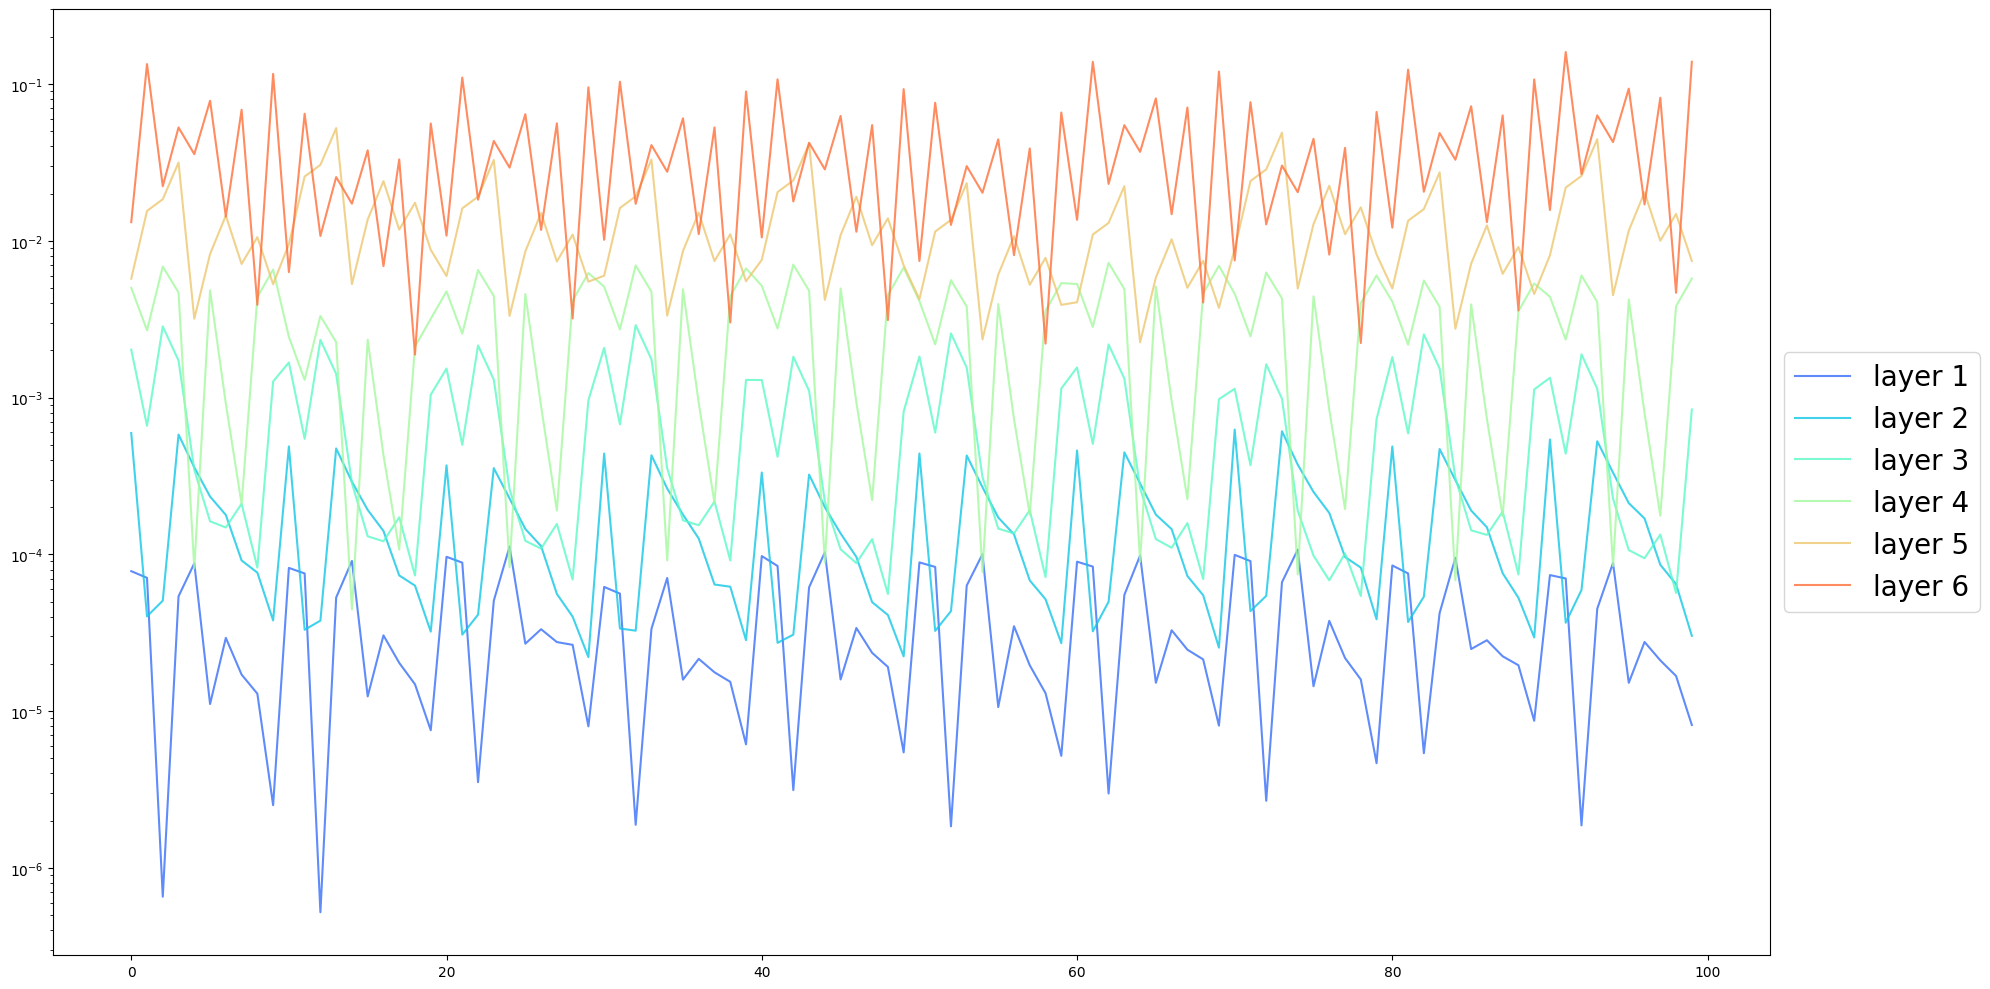

In [57]:
import os 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored 

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.metrics import Mean
from tensorflow.keras.metrics import SparseCategoricalAccuracy

train_ds, ds_info = tfds.load(name='mnist', shuffle_files=True,
                              as_supervised=True, split='train',
                              with_info=True)
def normalization(images, labels):
    images = tf.cast(images, tf.float32) / 255.
    return [images, labels]

n_layer = 7
cmap = cm.get_cmap('rainbow', lut=n_layer+1)
units = [10]*n_layer


model = Sequential()
model.add(Flatten())
for layer_idx in range(n_layer - 1):
    model.add(Dense(units[layer_idx], activation='sigmoid'))
model.add(Dense(units=10, activation='softmax'))

# model.build(input_shape=(None, 28, 28, 1))
# model.summary()

train_batch_size = 10
train_ds = train_ds.map(normalization).batch(train_batch_size)

loss_object = SparseCategoricalCrossentropy()
optimizer = SGD()

train_ds_iter = iter(train_ds)
images, labels = next(train_ds_iter)

print(images.shape, labels.shape)

with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)

gradients = tape.gradient(loss, model.trainable_variables)

fig, ax = plt.subplots(figsize=(20,10))
ax.set_yscale('log')
for grad_idx, grad in enumerate(gradients[::2]):
    if grad_idx >= 1:
        grad_abs = np.abs(grad.numpy().flat)
        ax.plot(grad_abs,
                label='layer {}'.format(grad_idx),
                color=cmap(grad_idx),
                alpha=0.8)
        
ax.legend(bbox_to_anchor=(1,0.5), loc='center left', fontsize=20)
fig.tight_layout()

# Conv and Pooling layer

In [9]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

                                        # same은 (k-1)/2,  홀수개로 height과 width를 만듬. 
conv = Conv2D(filters=8, kernel_size=3, padding='valid', activation='relu')
pool = MaxPooling2D(pool_size=2, strides=2)

image = tf.random.normal(mean=0, stddev=1, shape=(1, 28, 28, 3))

# print(image.shape)
conved = conv(image)
# print(conved.shape) # filter가 8개이기 때문에 axis=-1 ==> 8

print('w: ', conv.get_weights()[0].shape)
print('b: ', conv.get_weights()[1].shape)

pooled = pool(conved)
print(pooled.shape) # (26 + 0 - 2)/2 + 1



w:  (3, 3, 3, 8)
b:  (8,)
(1, 13, 13, 8)


In [13]:
conv1 = Conv2D(filters=8, kernel_size=3, padding='valid', activation='relu')
pool1 = MaxPooling2D(pool_size=2, strides=2)

conv2 = Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu')
pool2 = MaxPooling2D(pool_size=2, strides=2)

conv3 = Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu')
pool3 = MaxPooling2D(pool_size=2, strides=2)

print(image.shape)
conved = conv1(image)
print(conved.shape)
pooled = pool1(conved)
print(pooled.shape)

conved = conv2(pooled)
print(conved.shape)
pooled = pool2(conved)
print(pooled.shape)

conved = conv3(pooled)
print(conved.shape)
pooled = pool3(conved)
print(pooled.shape)

(1, 28, 28, 3)
(1, 26, 26, 8)
(1, 13, 13, 8)
(1, 11, 11, 16)
(1, 5, 5, 16)
(1, 3, 3, 32)
(1, 1, 1, 32)


In [14]:
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
